In [1]:
from qiskit import transpile ,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Operator, DensityMatrix, partial_trace, Pauli
from qiskit.visualization import plot_state_qsphere
from qiskit.circuit import Parameter, ParameterVector
from qiskit.circuit.library import RYGate, RZGate, CXGate, CRYGate, n_local
import numpy as np, array
from IPython.display import display, Latex
# SciPy minimizer routine
from scipy.optimize import minimize
#from skquant.interop.scipy import imfil
import time
from pathlib import Path
from qadc.circuits import *
from qadc.utils import *

# project_root = Path().resolve() / "risulati_ottimizzatore"
# project_root.mkdir(exist_ok = True) # Preleva il percorso assoluto di questo notebook

# Fase 1 Modellare il problema

## Modello Ancilla & Encoding

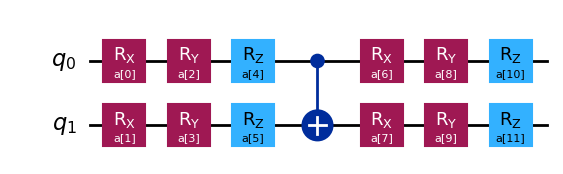

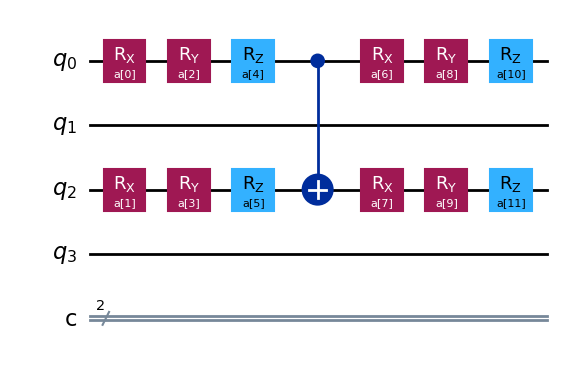

In [7]:

# 2 qubit, rotazioni RX/RY/RZ, entanglement CNOT
En = n_local(num_qubits=2,
              rotation_blocks=['rx', 'ry', 'rz'],
              entanglement_blocks='cx',
              reps=1,        # quante volte ripetere lo schema
              parameter_prefix="a",
              insert_barriers=False)

qc = QuantumCircuit(4,2)
# Possiamo per il momento omettere l'ottimizzazione di stati misti, per questo scelgo invece di 6 qubit, 4 qubit di cui 2 
# di sistema e 2 di ambiente
# qc.compose(AncillaInitializationCircuit(Parameter("A")),[0,2], inplace=True )
# qc.compose(AncillaInitializationCircuit(Parameter("B")),[3,5], inplace=True )

qc.compose(En, [0,2], inplace=True) # con ancilla avrò [0,3]
display(En.draw("mpl"))
display(qc.draw("mpl"))

## Modello Decoding 

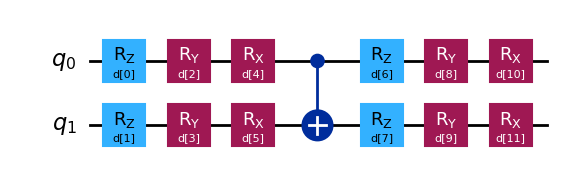

In [8]:
De = n_local(num_qubits=2,
              rotation_blocks=['rz', 'ry', 'rx'],
              entanglement_blocks='cx',
              reps=1,        # quante volte ripetere lo schema
              parameter_prefix="d",
              insert_barriers=False)
De.draw("mpl")

## Modello Completo

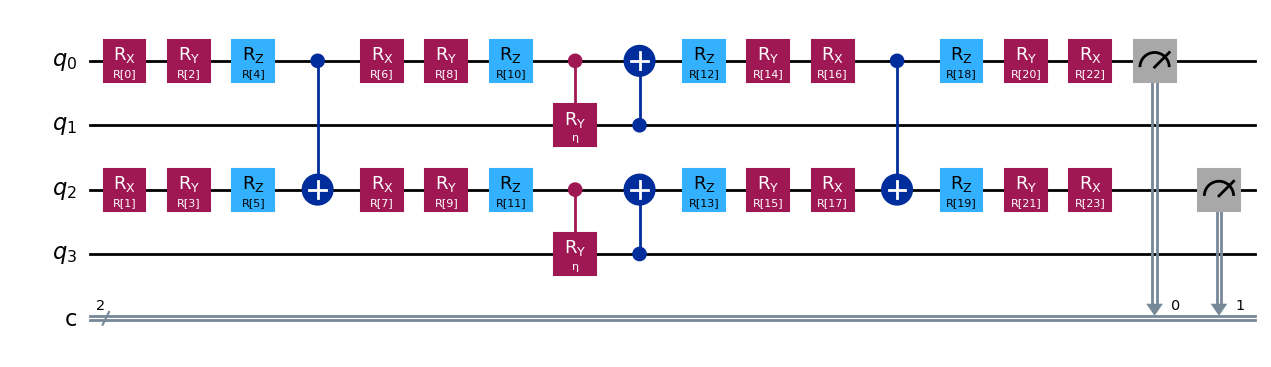

In [9]:
Ad = AmplitudeDampingConvenzioneQiskit()
qc.compose(Ad,[0,1], inplace = True) # con ancilla rimane cosi
qc.compose(Ad,[2,3], inplace = True) # con ancilla avrò 
qc.compose(De, [0,2], inplace = True)

param_circuit = qc.parameters.data
param_circuit.remove(Ad.parameters.data[0])

new_param_circuit = ParameterVector("R", len(param_circuit))
qc.assign_parameters({ param_circuit[i] : new_param_circuit[i] for i in range(qc.num_parameters-1)}, inplace=True)
qc.measure(0,0)
qc.measure(2,1)
qc.draw("mpl")